In [32]:
# Import libraries and set desired options

from __future__ import division, print_function
# Disable Anaconda warnings
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV, RandomizedSearchCV, KFold
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

In [2]:
# A helper function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [3]:
def analyze_results(cv_res):
    import re 
    
    results = pd.DataFrame(cv_res['params'])
    results['mean_score'] = cv_res['mean_test_score']
    results['std_score'] = cv_res['std_test_score']
    results['rank'] = cv_res['rank_test_score']
#     results = results.sort_values('rank')
    
    n_splits = len(cv_res['split0_test_score'])
    cv_results = np.r_[[clf.cv_results_[k] for k in clf.cv_results_.keys() if re.match(r'split\d+_test', k)]]
    cv_results = pd.DataFrame(cv_results)
    melted = cv_results.melt()
    melted['split_num'] = list(range(cv_results.shape[0])) * cv_results.shape[1]
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10), gridspec_kw={'width_ratios':[2, 1]})
    
    sns.barplot(x='split_num', y='value', hue='variable', data=melted, ax=axes[0, 0]);
    axes[0, 0].set_ylim(melted['value'].min()-.01, 1);
    
    sns.violinplot(x='variable', y='value', hue='variable', data=cv_results.melt(), ax=axes[0, 1], dodge=False);
    sns.boxplot(x='variable', y='value', data=melted, ax=axes[1, 0]);
    sns.barplot(x=results.index, y='std_score', data=results, ax=axes[1, 1]);
    
    sns.despine()
    return results, cv_results

## Load data

In [4]:
# Load websites dictionary
with open(r"data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), columns=['site'])

# sites_dict['zone'] = sites_dict['site'].str.split('.').apply(lambda x: x[-1])
# sites_dict.loc[sites_dict['zone'].str.isnumeric(), 'zone'] = 'ip_address'
# sites_dict['zone_le'] = LabelEncoder().fit_transform(sites_dict['zone'])

print(u'Websites total:', sites_dict.shape[0])

Websites total: 48371


In [5]:
# Read the training and test data sets
train_df = pd.read_csv('data/train_sessions.csv',
                      index_col='session_id')
test_df = pd.read_csv('data/test_sessions.csv',
                      index_col='session_id')

In [6]:
# Switch time1, ..., time10 columns to datetime type
times = ['time%s' % i for i in range(1, 11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [7]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Dataframe with indices of visited websites in session
full_sites = full_df[sites]

# Index to split the training and test data sets
idx_split = train_df.shape[0]

### get time features

In [8]:
def get_time_features(df):
    time_df = pd.DataFrame(index=df.index)
    
    hour = df['time1'].dt.hour
    time_df['hour'] = hour
    time_df['day_'] = df['time1'].dt.day
    time_df['month'] = df['time1'].dt.month
    time_df['year'] = df['time1'].dt.year
    time_df['myear'] = df['time1'].dt.year * 12 + df['time1'].dt.month
    
    time_df['morning'] = ((hour >= 7) & (hour <= 11)).astype('int')
    time_df['day'] = ((hour >= 12) & (hour <= 18)).astype('int')
    time_df['evening'] = ((hour >= 19) & (hour <= 23)).astype('int')

    time_df['min'] = df['time1'] 
    time_df['max'] = df[times].max(axis=1)

    for px in ['min', 'max']:
        time_df['minutes'] = time_df[px].dt.hour * 60 + time_df[px].dt.minute
        time_df['sin_'+px] = np.sin(2*np.pi*time_df['minutes']/1440.)
        time_df['cos_'+px] = np.cos(2*np.pi*time_df['minutes']/1440.)

    time_df['dow'] = time_df['min'].apply(lambda ts: ts.date().weekday())
    time_df['weekend'] = (time_df['dow'] > 4).astype('int')
    time_df['n_null'] = df[times].isnull().sum(axis=1)

    time_df['dt'] = time_df['max'] - time_df['min']
    for time in times[1:]:
        dt_ = (df[time] - time_df['min']).fillna(time_df['dt'])
        time_df['dt_' + time] = np.log1p(np.abs(dt_.astype('timedelta64[s]')))
    time_df['dt'] = np.log1p(np.abs(time_df['dt'].astype('timedelta64[s]')))
    time_df['dt_mean'] = time_df[['dt_' + time for time in times[1:]]].mean(axis=1)
    time_df['dt_std'] = time_df[['dt_' + time for time in times[1:]]].std(axis=1)
    time_df['dt_var'] = time_df[['dt_' + time for time in times[1:]]].var(axis=1)
    
    s_columns = [col for col in time_df.columns if time_df[col].dtype != '<M8[ns]']
    
#     s_scaler = StandardScaler()
#     time_df[s_columns] = s_scaler.fit_transform(time_df[s_columns])

    time_df = time_df.drop(['min', 'max'], axis=1)
    time_df = time_df.drop(['dt_' + time for time in times[1:]], axis=1)
    
    for col in time_df.columns:
        time_df[col] = time_df[col].fillna(time_df[col].mean())

    return time_df

In [9]:
full_time = get_time_features(full_df[times])
ft_columns = full_time.columns

hours_dum = pd.get_dummies(pd.cut(full_time['hour'], bins=4))
full_time = pd.concat([full_time, hours_dum], axis=1)
print(ft_columns)

Index(['hour', 'day_', 'month', 'year', 'myear', 'morning', 'day', 'evening',
       'minutes', 'sin_min', 'cos_min', 'sin_max', 'cos_max', 'dow', 'weekend',
       'n_null', 'dt', 'dt_mean', 'dt_std', 'dt_var'],
      dtype='object')


### get site features

In [10]:
full_sites_tf = full_sites.copy()

for col in full_sites_tf.columns:
    full_sites_tf[col] = full_sites_tf[col].map(sites_dict.site)

full_sites_tf = full_sites_tf.fillna('')
# df_tf_col = full_sites_tf.apply(lambda x: '.'.join([i for i in x if len(i)>0]), axis=1)
# df_tf_col = df_tf_col.str.split('[.-]').str.join(' ')

text_cols = ['sites', 'sites_ds', 'sites_dms', 'sites_num']
df_text = pd.DataFrame(columns=text_cols)

df_text['sites'] = full_sites_tf.apply(lambda x: ' '.join([i for i in x if len(i)>0]), axis=1)
df_text['sites_ds'] = df_text['sites'].str.split('[.]').str.join(' ')   # dot split
df_text['sites_dms'] = df_text['sites'].str.split('[.-]').str.join(' ')   # dot, minus split
df_text['sites_num'] = full_sites.astype('str').apply(lambda x: ' '.join(x), axis=1)

### concat features

In [11]:
X_train = pd.concat([df_text.iloc[:idx_split], full_time.iloc[:idx_split]], axis=1)
X_test = pd.concat([df_text.iloc[idx_split:], full_time.iloc[idx_split:]], axis=1)

X_train.tail(1)

,sites,sites_ds,sites_dms,sites_num,hour,day_,month,year,myear,morning,...,weekend,n_null,dt,dt_mean,dt_std,dt_var,"(6.984, 11.0]","(11.0, 15.0]","(15.0, 19.0]","(19.0, 23.0]"
session_id,,,,,,,,,,,,,,,,,,,,,
204762,ocsp.thawte.com www.dropbox.com www.dropbox.co...,ocsp thawte com www dropbox com www dropbox co...,ocsp thawte com www dropbox com www dropbox co...,222 3346 3346 3359 55 2891 3346 0 0 0,23,30,4,2014,24172,0,...,0,3,2.564949,2.442222,0.245807,0.060421,0,0,0,1


# Pipeline

In [12]:
class TextSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on text columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [13]:
pl_text_tfidf = Pipeline([
                ('select', TextSelector(key='sites_num')),
                ('tfidf', TfidfVectorizer(max_df=0.2, max_features=8000, smooth_idf=True, sublinear_tf=True))
                ])

pl_text_count = Pipeline([
                ('select', TextSelector(key='sites_num')),
                ('count', CountVectorizer(max_df=0.2))
                ])

pl_time = Pipeline([
                ('select', NumberSelector(key=ft_columns)),
#                 ('scale', StandardScaler())
                ])

pl_time_scale = Pipeline([
                ('select', NumberSelector(key=ft_columns)),
                ('scale', StandardScaler())
                ])

feats = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
#                     ('pl_time', pl_time),
                    ('pl_time_scale', pl_time_scale)
                    ])


feats_ns = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
                    ('pl_time', pl_time),
#                     ('pl_time_scale', pl_time_scale)
                    ])

feats_all = FeatureUnion([
                    ('pl_text', pl_text_tfidf), 
                    ('pl_time', pl_time),
                    ('pl_time_scale', pl_time_scale)
                    ])


pl = Pipeline([
                ('feats', feats),
                ('clf', LogisticRegression(C=3, random_state=17))
              ])

pl_ns = Pipeline([
                ('feats', feats_ns),
                ('clf', LogisticRegression(C=3, random_state=17))
              ])

pl_all = Pipeline([
                ('feats', feats_all),
                ('clf', LogisticRegression(C=3, random_state=17))
              ])

# pl.fit_transform(X_train)

In [476]:
%%time

not_scale_cols = ['morning', 'day', 'evening', 'sin_min', 'cos_min', 'sin_max', 'cos_max', 'weekend']
scale_cols = ['hour', 'day_', 'month', 'year', 'myear', 'minutes', 'dow', 'n_null',
              'dt', 'dt_mean', 'dt_std', 'dt_var']

params = {
#             'clf__C': [1, 3, 10, 30],
            'feats__pl_time__select__key': [],
#                 'feats__pl_text__count__max_features': [5000, 8000, 10000, 15000, 20000, 25000, 50000],
#                  'feats__pl_text__count__max_df': [0.1, 0.2, 0.3],
#                  'feats__pl_text__count__ngram_range': [(1, 1), (1, 2)],
#                 'feats__pl_text__tfidf__norm': ['l1', 'l2'],
#                 'feats__pl_text__tfidf__use_idf': [True, False],
        }

time_split = TimeSeriesSplit(n_splits=10)

clf = GridSearchCV(pl, params, cv=time_split, verbose=1, scoring='roc_auc', n_jobs=-1)

clf.fit(X_train, y_train)

print(clf.best_params_, clf.best_score_)

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:  1.3min finished


{'clf__C': 3} 0.8758891615997804
CPU times: user 40 s, sys: 13.7 s, total: 53.7 s
Wall time: 1min 22s


# To scale or not to scale

In [15]:
%%time

time_split = TimeSeriesSplit(n_splits=10)

n_cols = len(ft_columns)
ft_cols = np.array(ft_columns)

mask_cols = np.zeros(len(ft_columns), dtype='bool')

cv_cols = ['cv' + str(j) for j in range(10)]
results = pd.DataFrame(np.zeros((n_cols*2, 12)), columns=['Col', 'Score'] + cv_cols)

for i in range(n_cols):
    mask_cols[i] = True
    
    results.loc[i, 'Col'] = ft_cols[i]
    ts_cols = ft_cols[mask_cols]

    results.loc[i, cv_cols] = cross_val_score(pl.set_params(feats__pl_time_scale__select__key=ts_cols), 
                      X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
    
    results.loc[i+n_cols, cv_cols] = cross_val_score(pl_ns.set_params(feats__pl_time__select__key=ts_cols), 
                      X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

    s1 = results.loc[i, cv_cols].mean()
    s2 = results.loc[i+n_cols, cv_cols].mean()
    
    results.loc[i, 'Score'] = s1
    results.loc[i+n_cols, 'Score'] = s2

    print(f'Column: {ft_cols[i]:<10} Score_s:{s1:.5f} Score_ns:{s2:.5f} Scale: {s1 > s2} ')
    mask_cols[i] = False

Column: hour       Score_s:0.90672 Score_ns:0.90664 Scale: True 
Column: day_       Score_s:0.87261 Score_ns:0.86138 Scale: True 
Column: month      Score_s:0.87545 Score_ns:0.87553 Scale: False 
Column: year       Score_s:0.87723 Score_ns:0.84114 Scale: True 
Column: myear      Score_s:0.87606 Score_ns:0.70731 Scale: True 
Column: morning    Score_s:0.92410 Score_ns:0.92411 Scale: False 
Column: day        Score_s:0.92675 Score_ns:0.92638 Scale: True 
Column: evening    Score_s:0.87861 Score_ns:0.87820 Scale: True 
Column: minutes    Score_s:0.90683 Score_ns:0.90409 Scale: True 
Column: sin_min    Score_s:0.91757 Score_ns:0.91758 Scale: False 
Column: cos_min    Score_s:0.88261 Score_ns:0.88261 Scale: False 
Column: sin_max    Score_s:0.91747 Score_ns:0.91747 Scale: False 
Column: cos_max    Score_s:0.88274 Score_ns:0.88274 Scale: False 
Column: dow        Score_s:0.87561 Score_ns:0.87537 Scale: True 
Column: weekend    Score_s:0.86175 Score_ns:0.86448 Scale: False 
Column: n_null    

Column: hour       Score_s:0.90672 Score_ns:0.90664 Scale: True  
Column: day_       Score_s:0.87261 Score_ns:0.86138 Scale: True  
Column: month      Score_s:0.87545 Score_ns:0.87553 Scale: False  
Column: year       Score_s:0.87723 Score_ns:0.84114 Scale: True  
Column: myear      Score_s:0.87606 Score_ns:0.70731 Scale: True  
Column: morning    Score_s:0.92410 Score_ns:0.92411 Scale: False  
Column: day        Score_s:0.92675 Score_ns:0.92638 Scale: True  
Column: evening    Score_s:0.87861 Score_ns:0.87820 Scale: True  
Column: minutes    Score_s:0.90683 Score_ns:0.90409 Scale: True  
Column: sin_min    Score_s:0.91757 Score_ns:0.91758 Scale: False  
Column: cos_min    Score_s:0.88261 Score_ns:0.88261 Scale: False  
Column: sin_max    Score_s:0.91747 Score_ns:0.91747 Scale: False  
Column: cos_max    Score_s:0.88274 Score_ns:0.88274 Scale: False  
Column: dow        Score_s:0.87561 Score_ns:0.87537 Scale: True  
Column: weekend    Score_s:0.86175 Score_ns:0.86448 Scale: False  
Column: n_null     Score_s:0.87416 Score_ns:0.87413 Scale: True   
Column: dt         Score_s:0.87476 Score_ns:0.87458 Scale: True  
Column: dt_mean    Score_s:0.87493 Score_ns:0.87480 Scale: True  
Column: dt_std     Score_s:0.87552 Score_ns:0.87541 Scale: True  
Column: dt_var     Score_s:0.87550 Score_ns:0.87539 Scale: True  
CPU times: user 5min 3s, sys: 2min 1s, total: 7min 4s   
Wall time: 12min 31s    

# Find useful features

In [115]:
%%time
n_splits=2
time_split = TimeSeriesSplit(n_splits=n_splits)

sc_cols = ['hour', 'day_', 'month', 'year', 'myear', 'minutes', 'dow', 'n_null', 'dt', 'dt_mean', 'dt_std', 'dt_var']

n_cols = len(sc_cols)
ft_cols = np.array(sc_cols)

mask_cols = np.zeros(len(sc_cols), dtype='bool')

cv_cols = ['cv' + str(j) for j in range(n_splits)]
results = pd.DataFrame(np.zeros((n_cols, 1+n_splits)), columns=['Col'] + cv_cols)
sc_dict = {x:0 for x in sc_cols}

for r in range(5, 12):
    print(f"Iter {r}")
    score = 0.8758
    np.random.seed(r)
    np.random.shuffle(ft_cols)
    for i in range(n_cols):
        score_ = 0

        mask_cols[i] = True

        results.loc[i, 'Col'] = ft_cols[i]
        ts_cols = ft_cols[mask_cols]

        results.loc[i, cv_cols] = cross_val_score(pl.set_params(feats__pl_time_scale__select__key=ts_cols), 
                          X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

        score_ = results.loc[i, cv_cols].mean()

        if score_ - score < 0.00005:
            mask_cols[i] = False
        else:
            score = score_
            sc_dict[ft_cols[i]] += 1

        print(f'Column: {results.loc[i, "Col"]:<10} Score:{score_:.5f} Use: {mask_cols[i]} ')
    print('*' * 30)

Iter 5
Column: n_null     Score:0.87340 Use: False 
Column: minutes    Score:0.91721 Use: True 
Column: month      Score:0.91914 Use: True 
Column: dt_mean    Score:0.91955 Use: True 
Column: dt_var     Score:0.91975 Use: True 
Column: myear      Score:0.92065 Use: True 
Column: dt         Score:0.92037 Use: False 
Column: day_       Score:0.92073 Use: True 
Column: hour       Score:0.92063 Use: False 
Column: dt_std     Score:0.92080 Use: True 
Column: dow        Score:0.92435 Use: True 
Column: year       Score:0.92436 Use: False 
******************************
Iter 6
Column: hour       Score:0.92057 Use: True 
Column: year       Score:0.92057 Use: False 
Column: minutes    Score:0.91888 Use: False 
Column: dt         Score:0.91913 Use: False 
Column: n_null     Score:0.91904 Use: False 
Column: day_       Score:0.91887 Use: False 
Column: myear      Score:0.92052 Use: False 
Column: month      Score:0.91956 Use: False 
Column: dt_var     Score:0.91793 Use: False 
Column: dt_mean    

Column: dow        Score:0.88317 Use: True 
Column: dt_var     Score:0.88370 Use: True 
Column: myear      Score:0.88550 Use: True 
Column: dt_std     Score:0.88570 Use: True 
Column: month      Score:0.88938 Use: True 
Column: dt         Score:0.88948 Use: True 
Column: day_       Score:0.89017 Use: True 
Column: n_null     Score:0.88972 Use: False 
Column: dt_mean    Score:0.89001 Use: False 
Column: year       Score:0.89017 Use: False 
Column: hour       Score:0.92433 Use: True 
Column: minutes    Score:0.92427 Use: False 
------------------------------
Iter 1
Column: myear      Score:0.92428 Use: True 
Column: dt_std     Score:0.92428 Use: False 
Column: month      Score:0.92423 Use: False 
Column: hour       Score:0.91981 Use: False 
Column: dt_var     Score:0.88454 Use: False 
Column: day_       Score:0.88417 Use: False 
Column: dow        Score:0.88525 Use: False 
Column: n_null     Score:0.87465 Use: False 
Column: minutes    Score:0.91832 Use: False 
Column: year       Score:0.87799 Use: False 
Column: dt_mean    Score:0.87485 Use: False 
Column: dt         Score:0.87492 Use: False 

In [ ]:
%%time

time_split = TimeSeriesSplit(n_splits=10)

sc_cols = ['morning', 'day', 'evening', 'sin_min', 'cos_min', 'sin_max', 'cos_max']

n_cols = len(sc_cols)
ft_cols = np.array(sc_cols)

mask_cols = np.zeros(len(sc_cols), dtype='bool')

cv_cols = ['cv' + str(j) for j in range(10)]
results = pd.DataFrame(np.zeros((n_cols, 11)), columns=['Col'] + cv_cols)
sc_dict_ = {x:0 for x in sc_cols}

for r in range(30):
    print(f"Iter {r}")
    score = 0.8758
    np.random.seed(r)
    np.random.shuffle(ft_cols)
    for i in range(n_cols):
        score_ = 0

        mask_cols[i] = True

        results.loc[i, 'Col'] = ft_cols[i]
        ts_cols = ft_cols[mask_cols]

        results.loc[i, cv_cols] = cross_val_score(pl_ns.set_params(feats__pl_time__select__key=ts_cols), 
                          X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

        score_ = results.loc[i, cv_cols].mean()

        if score_ < score:
            mask_cols[i] = False
        else:
            score = score_
            sc_dict_[ft_cols[i]] += 1

        print(f'Column: {results.loc[i, "Col"]:<10} Score:{score_:.5f} Use: {mask_cols[i]} ')
    print('-' * 30)

{'hour': 10,
 'day_': 1,
 'month': 7,
 'year': 12,
 'myear': 17,
 'minutes': 17,
 'dow': 8,
 'n_null': 1,
 'dt': 5,
 'dt_mean': 4,
 'dt_std': 6,
 'dt_var': 15}
 
 {'morning': 23,
 'day': 30,
 'evening': 25,
 'sin_min': 24,
 'cos_min': 27,
 'sin_max': 26,
 'cos_max': 25}

In [31]:
[z for z in pl_all.get_params().keys() if 'key' in z]

['feats__pl_text__select__key',
 'feats__pl_time__select__key',
 'feats__pl_time_scale__select__key']

In [16]:
X_train.columns = [      'sites',    'sites_ds',   'sites_dms',   'sites_num',
              'hour',        'day_',       'month',        'year',
             'myear',     'morning',         'day',     'evening',
           'minutes',     'sin_min',     'cos_min',     'sin_max',
           'cos_max',         'dow',     'weekend',      'n_null',
                'dt',     'dt_mean',      'dt_std',      'dt_var',
       'spl1',  'spl2',  'spl3',  'spl4']

X_test.columns = X_train.columns

In [101]:
%%time



s_cols = [['hour', 'year', 'myear', 'minutes', 'dt_var'],
          ['dow', 'month', 'dt_var', 'dt_mean', 'dt_std', 'day_'],
          ['dow', 'month', 'dt_var', 'dt_mean', 'dt_std', 'day_'],
         ['dow', 'month', 'minutes', 'dt_var'],
         ['dow', 'month', 'minutes', 'dt_var', 'dt_mean', 'dt_std', 'day']]
ns_cols = [['spl1',  'spl2',  'spl3',  'spl4'],
           ['spl1',  'spl2',  'spl3',  'spl4', 'sin_max', 'cos_max'],
           ['spl1',  'spl2',  'spl3',  'spl4', 'sin_max', 'cos_max'],
          ['spl1',  'spl2',  'spl3',  'spl4'],
          ['spl1',  'spl2',  'spl3',  'spl4']]

max_df_cols = [.2,.2,.7,.2,.2]

# s_cols = ['dow', 'month', 'dt_var', 'dt_mean', 'dt_std', 'day_']
# ns_cols = ['spl1',  'spl2',  'spl3',  'spl4', 'sin_max', 'cos_max']

# pl_all.set_params(feats__pl_time__select__key=ns_cols, feats__pl_time_scale__select__key=s_cols,
#                  feats__pl_text__tfidf__max_df=0.7).fit(X_train, y_train)

pub_lb = [0.9298, 0.9348, 0.9352, 0.9394, 0.9411]

scores= dict()

for k in range(2, 13):
    scores[k] = list()
    print(f"k = {k}")
    time_split = TimeSeriesSplit(n_splits=k)
#     time_split = KFold(n_splits=k, shuffle=False)


    n_cols = len(s_cols)
    cv_cols = ['cv' + str(j) for j in range(10)]
#     results = pd.DataFrame(np.zeros((n_cols, 11)), columns=['Col'] + cv_cols)

    for i in range(n_cols):

#         results.loc[i, 'Col'] = i

        s = cross_val_score(pl_all.set_params(feats__pl_time__select__key=ns_cols[i],
                                            feats__pl_time_scale__select__key=s_cols[i],
                                             feats__pl_text__tfidf__max_df=max_df_cols[i]),
                                                  X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)

#         score_ = s.mean()
        scores[k].append(s)
        print(f'Column: {i} Score:{s.mean():.4f}+-{s.std():.4f} pub_lb: {pub_lb[i]:.4f}  ')
    print('*' * 30)

k = 2
Column: 0 Score:0.9512+-0.0089 pub_lb: 0.9298  
Column: 1 Score:0.9525+-0.0072 pub_lb: 0.9348  
Column: 2 Score:0.9523+-0.0076 pub_lb: 0.9352  
Column: 3 Score:0.9509+-0.0100 pub_lb: 0.9394  
Column: 4 Score:0.9514+-0.0101 pub_lb: 0.9411  
******************************
k = 3
Column: 0 Score:0.9490+-0.0181 pub_lb: 0.9298  
Column: 1 Score:0.9503+-0.0149 pub_lb: 0.9348  
Column: 2 Score:0.9496+-0.0157 pub_lb: 0.9352  
Column: 3 Score:0.9490+-0.0173 pub_lb: 0.9394  
Column: 4 Score:0.9496+-0.0173 pub_lb: 0.9411  
******************************
k = 4
Column: 0 Score:0.9314+-0.0490 pub_lb: 0.9298  
Column: 1 Score:0.9260+-0.0630 pub_lb: 0.9348  
Column: 2 Score:0.9253+-0.0642 pub_lb: 0.9352  
Column: 3 Score:0.9371+-0.0421 pub_lb: 0.9394  
Column: 4 Score:0.9381+-0.0411 pub_lb: 0.9411  
******************************
k = 5
Column: 0 Score:0.9199+-0.0661 pub_lb: 0.9298  
Column: 1 Score:0.8988+-0.1129 pub_lb: 0.9348  
Column: 2 Score:0.8977+-0.1143 pub_lb: 0.9352  
Column: 3 Score:0.9

In [112]:
scores[10]

[array([0.6699654 , 0.81788942, 0.96978259, 0.96861404, 0.924379  ,
        0.97675274, 0.92717744, 0.9500498 , 0.97442405, 0.97364177]),
 array([0.64219609, 0.75120815, 0.96340632, 0.96893535, 0.9308179 ,
        0.97537204, 0.90323302, 0.95135484, 0.97562234, 0.98080977]),
 array([0.64003451, 0.75000135, 0.96367505, 0.96711823, 0.93007607,
        0.97509269, 0.90240136, 0.95192411, 0.97547809, 0.9807077 ]),
 array([0.65135411, 0.80683067, 0.96131689, 0.97096088, 0.92470623,
        0.97515072, 0.92379128, 0.95156365, 0.97442985, 0.9789706 ]),
 array([0.65104944, 0.81101446, 0.96171718, 0.97035083, 0.9245789 ,
        0.9756117 , 0.92558811, 0.95257039, 0.97563684, 0.97937653])]

k = 4
Column: 0 Score:0.9314+-0.0490 pub_lb: 0.9230
Column: 1 Score:0.9260+-0.0630 pub_lb: 0.9350
Column: 2 Score:0.9371+-0.0421 pub_lb: 0.9390
Column: 3 Score:0.9381+-0.0411 pub_lb: 0.9410
++++++++++++++++++++++++++++++
k = 8
Column: 0 Score:0.9059+-0.0939 pub_lb: 0.9230
Column: 1 Score:0.9059+-0.0916 pub_lb: 0.9350
Column: 2 Score:0.9069+-0.0926 pub_lb: 0.9390
Column: 3 Score:0.9078+-0.0918 pub_lb: 0.9410
++++++++++++++++++++++++++++++
k = 10
Column: 0 Score:0.9153+-0.0936 pub_lb: 0.9230
Column: 1 Score:0.9043+-0.1090 pub_lb: 0.9350
Column: 2 Score:0.9119+-0.0996 pub_lb: 0.9390
Column: 3 Score:0.9127+-0.0994 pub_lb: 0.9410
++++++++++++++++++++++++++++++
CPU times: user 1min 9s, sys: 28.7 s, total: 1min 37s

In [53]:
pub_lb = np.array(pub_lb)
pub_lb[1:] - pub_lb[:3]

array([0.012, 0.004, 0.002])

In [96]:
scores_temp = scores.copy()

In [95]:
z = np.array(scores[10])
mask = [False,  False,  False,  True,  True,  False,  True,  True,  True, True]
print((z.T[mask, 1:] - z.T[mask, :3]).mean(axis=0))
mask = [False,  False,  False,  True,  True,  False,  True,  True,  True, True]
print((z.T[mask, 1:] - z.T[mask, :3]).mean(axis=0))

[-0.00125215  0.00227488  0.00061319]
[-0.00125215  0.00227488  0.00061319]


In [57]:
z[1:, :] - z[:3, :]

array([[-0.02991923,  0.00396873, -0.00046342,  0.00454786],
       [ 0.04861634, -0.00537681,  0.00240264, -0.00128582],
       [ 0.00276791,  0.00038948,  0.00061672,  0.00050791]])

In [63]:

for i in range(len(z[0])):
    print(z[:, i])
    print(z[1:, i] - z[:3, i])
    print()

[0.6699654  0.64219609 0.65135411 0.65104944]
[-0.02776931  0.00915802 -0.00030467]

[0.81788942 0.75120815 0.80683067 0.81101446]
[-0.06668127  0.05562252  0.00418379]

[0.96978259 0.96340632 0.96131689 0.96171718]
[-0.00637627 -0.00208943  0.00040029]

[0.96861404 0.96893535 0.97096088 0.97035083]
[ 0.00032131  0.00202553 -0.00061005]

[0.924379   0.9308179  0.92470623 0.9245789 ]
[ 0.00643891 -0.00611168 -0.00012732]

[0.97675274 0.97537204 0.97515072 0.9756117 ]
[-0.0013807  -0.00022132  0.00046099]

[0.92717744 0.90323302 0.92379128 0.92558811]
[-0.02394442  0.02055826  0.00179684]

[0.9500498  0.95135484 0.95156365 0.95257039]
[0.00130504 0.00020881 0.00100674]

[0.97442405 0.97562234 0.97442985 0.97563684]
[ 0.00119829 -0.0011925   0.00120699]

[0.97364177 0.98080977 0.9789706  0.97937653]
[ 0.007168   -0.00183917  0.00040593]



k = 3
Column: 0 Score:0.9490+-0.0181 pub_lb: 0.929
Column: 1 Score:0.9490+-0.0173 pub_lb: 0.939
Column: 2 Score:0.9496+-0.0173 pub_lb: 0.941
*------------------------------
k = 4
Column: 0 Score:0.9314+-0.0490 pub_lb: 0.929
Column: 1 Score:0.9371+-0.0421 pub_lb: 0.939
Column: 2 Score:0.9381+-0.0411 pub_lb: 0.941
*------------------------------
k = 5
Column: 0 Score:0.9199+-0.0661 pub_lb: 0.929
Column: 1 Score:0.9197+-0.0679 pub_lb: 0.939
Column: 2 Score:0.9210+-0.0661 pub_lb: 0.941
*------------------------------
k = 8
Column: 0 Score:0.9059+-0.0939 pub_lb: 0.929
Column: 1 Score:0.9069+-0.0926 pub_lb: 0.939
Column: 2 Score:0.9078+-0.0918 pub_lb: 0.941
*------------------------------
k = 10
Column: 0 Score:0.9153+-0.0936 pub_lb: 0.929
Column: 1 Score:0.9119+-0.0996 pub_lb: 0.939
Column: 2 Score:0.9127+-0.0994 pub_lb: 0.941
*------------------------------
CPU times: user 1min 9s, sys: 30.6 s, total: 1min 40s
Wall time: 4min 14s

k = 2
Column: 0 Score:0.9512+-0.0089 
Column: 1 Score:0.9509+-0.0100 
*------------------------------
k = 3
Column: 0 Score:0.9490+-0.0181 
Column: 1 Score:0.9490+-0.0173 
*------------------------------
k = 4
Column: 0 Score:0.9314+-0.0490 
Column: 1 Score:0.9371+-0.0421 
*------------------------------
k = 5
Column: 0 Score:0.9199+-0.0661 
Column: 1 Score:0.9197+-0.0679 
*------------------------------
k = 6
Column: 0 Score:0.9199+-0.0904 
Column: 1 Score:0.9173+-0.0974 
*------------------------------
k = 7
Column: 0 Score:0.9125+-0.0750 
Column: 1 Score:0.9099+-0.0821 
*------------------------------
k = 8
Column: 0 Score:0.9059+-0.0939 
Column: 1 Score:0.9069+-0.0926 
*------------------------------
k = 9
Column: 0 Score:0.9054+-0.0951 
Column: 1 Score:0.9039+-0.0999 
*------------------------------
k = 10
Column: 0 Score:0.9153+-0.0936 
Column: 1 Score:0.9119+-0.0996 
*------------------------------
k = 11
Column: 0 Score:0.9096+-0.0875 
Column: 1 Score:0.9052+-0.0975 
*------------------------------
k = 12
Column: 0 Score:0.9153+-0.0935 
Column: 1 Score:0.9123+-0.1007 
*------------------------------
k = 13
Column: 0 Score:0.9096+-0.0774 
Column: 1 Score:0.9077+-0.0844 
*------------------------------
CPU times: user 1min 59s, sys: 51.2 s, total: 2min 50s
Wall time: 6min 41s


In [33]:
X_test.columns

Index(['sites', 'sites_ds', 'sites_dms', 'sites_num', 'hour', 'day_', 'month',
       'year', 'myear', 'morning', 'day', 'evening', 'minutes', 'sin_min',
       'cos_min', 'sin_max', 'cos_max', 'dow', 'weekend', 'n_null', 'dt',
       'dt_mean', 'dt_std', 'dt_var', 'spl1', 'spl2', 'spl3', 'spl4'],
      dtype='object')

In [ ]:
s_cols = ['hour', 'year', 'myear', 'minutes', 'dt_var']
ns_cols = ['spl1',  'spl2',  'spl3',  'spl4']

s_cols = ['dow', 'month', 'minutes', 'dt_var']
ns_cols = ['spl1',  'spl2',  'spl3',  'spl4']

In [18]:
X_train.columns

Index(['sites', 'sites_ds', 'sites_dms', 'sites_num', 'hour', 'day_', 'month',
       'year', 'myear', 'morning', 'day', 'evening', 'minutes', 'sin_min',
       'cos_min', 'sin_max', 'cos_max', 'dow', 'weekend', 'n_null', 'dt',
       'dt_mean', 'dt_std', 'dt_var', 'spl1', 'spl2', 'spl3', 'spl4'],
      dtype='object')

In [43]:
[x for x in pl_all.get_params().keys() if 'max_df' in x]

['feats__pl_text__tfidf__max_df']

In [100]:
s_cols = ['dow', 'month', 'dt_var', 'dt_mean', 'dt_std', 'day_']
ns_cols = ['spl1',  'spl2',  'spl3',  'spl4', 'sin_max', 'cos_max']

pl_all.set_params(feats__pl_time__select__key=ns_cols, feats__pl_time_scale__select__key=s_cols,
                 feats__pl_text__tfidf__max_df=0.7).fit(X_train, y_train)

pred = pl_all.predict_proba(X_test)[:, 1]

write_to_submission_file(pred, 'pl_optim_4.csv')

In [16]:
ft_cols[mask_cols]

array(['minutes', 'dt_mean', 'day', 'myear', 'month', 'dt', 'year'],
      dtype=object)

In [526]:
%%time

time_split = TimeSeriesSplit(n_splits=10)

n_cols = len(ft_columns)
ft_cols = np.array(ft_columns)
mask_cols = np.zeros(len(ft_columns), dtype='bool')
mask_scale = np.zeros(len(ft_columns), dtype='bool')
cv_cols = ['cv' + str(j) for j in range(10)]
results = pd.DataFrame(np.zeros((n_cols*2, 12)), columns=['Col', 'Scale'] + cv_cols)

score = 0.8758
np.random.seed(0)
np.random.shuffle(ft_cols)
for i in range(n_cols):
    score_ = [0, 0]
    for use_scaler in [0, 1]:
        mask_cols[i] = True
        mask_scale[i] = True if use_scaler else False
        k = i + use_scaler
        
        results.iloc[k, 0] = ft_cols[i]
        results.iloc[k, 1] = use_scaler
        t_cols = ft_cols[mask_cols & ~mask_scale]
        ts_cols = ft_cols[mask_cols & mask_scale]

        results.iloc[k, cv_cols] = cross_val_score(pl.set_params(feats__pl_time__select__key=t_cols, feats__pl_time_scale__select__key=ts_cols), 
                          X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
        
        score_[use_scaler] = results.iloc[k, cv_cols].mean()
        
    if score_[0] < score and score_[1] < score:
        mask_cols[i] = False
        mask_scale[i] = False
        
    if score_[0] > score and score_[1] < score:
        mask_scale[i] = False
        
    if score_[0] > score or score_[1] > score:
        score = max(score_)
    
    print(f'Column: {results.iloc[k, 0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/runpy.py in _run_module_as_main(mod_name='ipykernel_launcher', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/runpy.py in _run_code(code=<code object <module> at 0x7f51c89065d0, file "/...3.7/site-packages/ipykernel_launcher.py", line 5>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ningenkun/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ningen.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), pkg_name='', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f51c89065d0, file "/...3.7/site-packages/ipykernel_launcher.py", line 5>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/ningenkun/anaconda3/lib/python3.7/site-packages/__pycache__/ipykernel_launcher.cpython-37.pyc', '__doc__': 'Entry point for launching an IPython kernel.\n\nTh...orts until\nafter removing the cwd from sys.path.\n', '__file__': '/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': '', '__spec__': ModuleSpec(name='ipykernel_launcher', loader=<_f...b/python3.7/site-packages/ipykernel_launcher.py'), 'app': <module 'ipykernel.kernelapp' from '/home/ningen.../python3.7/site-packages/ipykernel/kernelapp.py'>, ...}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py in <module>()
     11     # This is added back by InteractiveShellApp.init_path()
     12     if sys.path[0] == '':
     13         del sys.path[0]
     14 
     15     from ipykernel import kernelapp as app
---> 16     app.launch_new_instance()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    492         if self.poller is not None:
    493             self.poller.start()
    494         self.kernel.start()
    495         self.io_loop = ioloop.IOLoop.current()
    496         try:
--> 497             self.io_loop.start()
        self.io_loop.start = <bound method BaseAsyncIOLoop.start of <tornado.platform.asyncio.AsyncIOMainLoop object>>
    498         except KeyboardInterrupt:
    499             pass
    500 
    501 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in start(self=<tornado.platform.asyncio.AsyncIOMainLoop object>)
    127         except (RuntimeError, AssertionError):
    128             old_loop = None
    129         try:
    130             self._setup_logging()
    131             asyncio.set_event_loop(self.asyncio_loop)
--> 132             self.asyncio_loop.run_forever()
        self.asyncio_loop.run_forever = <bound method BaseEventLoop.run_forever of <_Uni...EventLoop running=True closed=False debug=False>>
    133         finally:
    134             asyncio.set_event_loop(old_loop)
    135 
    136     def stop(self):

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/asyncio/base_events.py in run_forever(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
    518         sys.set_asyncgen_hooks(firstiter=self._asyncgen_firstiter_hook,
    519                                finalizer=self._asyncgen_finalizer_hook)
    520         try:
    521             events._set_running_loop(self)
    522             while True:
--> 523                 self._run_once()
        self._run_once = <bound method BaseEventLoop._run_once of <_UnixS...EventLoop running=True closed=False debug=False>>
    524                 if self._stopping:
    525                     break
    526         finally:
    527             self._stopping = False

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/asyncio/base_events.py in _run_once(self=<_UnixSelectorEventLoop running=True closed=False debug=False>)
   1753                         logger.warning('Executing %s took %.3f seconds',
   1754                                        _format_handle(handle), dt)
   1755                 finally:
   1756                     self._current_handle = None
   1757             else:
-> 1758                 handle._run()
        handle._run = <bound method Handle._run of <Handle BaseAsyncIOLoop._handle_events(11, 1)>>
   1759         handle = None  # Needed to break cycles when an exception occurs.
   1760 
   1761     def _set_coroutine_origin_tracking(self, enabled):
   1762         if bool(enabled) == bool(self._coroutine_origin_tracking_enabled):

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/asyncio/events.py in _run(self=<Handle BaseAsyncIOLoop._handle_events(11, 1)>)
     83     def cancelled(self):
     84         return self._cancelled
     85 
     86     def _run(self):
     87         try:
---> 88             self._context.run(self._callback, *self._args)
        self._context.run = <built-in method run of Context object>
        self._callback = <bound method BaseAsyncIOLoop._handle_events of <tornado.platform.asyncio.AsyncIOMainLoop object>>
        self._args = (11, 1)
     89         except Exception as exc:
     90             cb = format_helpers._format_callback_source(
     91                 self._callback, self._args)
     92             msg = f'Exception in callback {cb}'

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/tornado/platform/asyncio.py in _handle_events(self=<tornado.platform.asyncio.AsyncIOMainLoop object>, fd=11, events=1)
    117             self.writers.remove(fd)
    118         del self.handlers[fd]
    119 
    120     def _handle_events(self, fd, events):
    121         fileobj, handler_func = self.handlers[fd]
--> 122         handler_func(fileobj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fileobj = <zmq.sugar.socket.Socket object>
        events = 1
    123 
    124     def start(self):
    125         try:
    126             old_loop = asyncio.get_event_loop()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    445             return
    446         zmq_events = self.socket.EVENTS
    447         try:
    448             # dispatch events:
    449             if zmq_events & zmq.POLLIN and self.receiving():
--> 450                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    451                 if not self.socket:
    452                     return
    453             if zmq_events & zmq.POLLOUT and self.sending():
    454                 self._handle_send()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    475             else:
    476                 raise
    477         else:
    478             if self._recv_callback:
    479                 callback = self._recv_callback
--> 480                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    481         
    482 
    483     def _handle_send(self):
    484         """Handle a send event."""

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    427         close our socket."""
    428         try:
    429             # Use a NullContext to ensure that all StackContexts are run
    430             # inside our blanket exception handler rather than outside.
    431             with stack_context.NullContext():
--> 432                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    433         except:
    434             gen_log.error("Uncaught exception in ZMQStream callback",
    435                           exc_info=True)
    436             # Re-raise the exception so that IOLoop.handle_callback_exception

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    295         # Fast path when there are no active contexts.
    296         def null_wrapper(*args, **kwargs):
    297             try:
    298                 current_state = _state.contexts
    299                 _state.contexts = cap_contexts[0]
--> 300                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    301             finally:
    302                 _state.contexts = current_state
    303         null_wrapper._wrapped = True
    304         return null_wrapper

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    278         if self.control_stream:
    279             self.control_stream.on_recv(self.dispatch_control, copy=False)
    280 
    281         def make_dispatcher(stream):
    282             def dispatcher(msg):
--> 283                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    284             return dispatcher
    285 
    286         for s in self.shell_streams:
    287             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 24, 14, 13, 44, 276856, tzinfo=tzlocal()), 'msg_id': 'eec75fedec90401889f8b52178acf4f3', 'msg_type': 'execute_request', 'session': '217cf8f80628413383ef242969270edf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'eec75fedec90401889f8b52178acf4f3', 'msg_type': 'execute_request', 'parent_header': {}})
    228             self.log.warning("Unknown message type: %r", msg_type)
    229         else:
    230             self.log.debug("%s: %s", msg_type, msg)
    231             self.pre_handler_hook()
    232             try:
--> 233                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'217cf8f80628413383ef242969270edf']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 24, 14, 13, 44, 276856, tzinfo=tzlocal()), 'msg_id': 'eec75fedec90401889f8b52178acf4f3', 'msg_type': 'execute_request', 'session': '217cf8f80628413383ef242969270edf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'eec75fedec90401889f8b52178acf4f3', 'msg_type': 'execute_request', 'parent_header': {}}
    234             except Exception:
    235                 self.log.error("Exception in message handler:", exc_info=True)
    236             finally:
    237                 self.post_handler_hook()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'217cf8f80628413383ef242969270edf'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': "%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': datetime.datetime(2018, 10, 24, 14, 13, 44, 276856, tzinfo=tzlocal()), 'msg_id': 'eec75fedec90401889f8b52178acf4f3', 'msg_type': 'execute_request', 'session': '217cf8f80628413383ef242969270edf', 'username': 'username', 'version': '5.2'}, 'metadata': {}, 'msg_id': 'eec75fedec90401889f8b52178acf4f3', 'msg_type': 'execute_request', 'parent_header': {}})
    394         if not silent:
    395             self.execution_count += 1
    396             self._publish_execute_input(code, parent, self.execution_count)
    397 
    398         reply_content = self.do_execute(code, silent, store_history,
--> 399                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    400 
    401         # Flush output before sending the reply.
    402         sys.stdout.flush()
    403         sys.stderr.flush()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code="%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    203 
    204         self._forward_input(allow_stdin)
    205 
    206         reply_content = {}
    207         try:
--> 208             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = "%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')"
        store_history = True
        silent = False
    209         finally:
    210             self._restore_input()
    211 
    212         if res.error_before_exec is not None:

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=("%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')",), **kwargs={'silent': False, 'store_history': True})
    532             )
    533         self.payload_manager.write_payload(payload)
    534 
    535     def run_cell(self, *args, **kwargs):
    536         self._last_traceback = None
--> 537         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ("%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')",)
        kwargs = {'silent': False, 'store_history': True}
    538 
    539     def _showtraceback(self, etype, evalue, stb):
    540         # try to preserve ordering of tracebacks and print statements
    541         sys.stdout.flush()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", store_history=True, silent=False, shell_futures=True)
   2657         -------
   2658         result : :class:`ExecutionResult`
   2659         """
   2660         try:
   2661             result = self._run_cell(
-> 2662                 raw_cell, store_history, silent, shell_futures)
        raw_cell = "%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')"
        store_history = True
        silent = False
        shell_futures = True
   2663         finally:
   2664             self.events.trigger('post_execute')
   2665             if not silent:
   2666                 self.events.trigger('post_run_cell', result)

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in _run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell="%%time\n\ntime_split = TimeSeriesSplit(n_splits=10...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", store_history=True, silent=False, shell_futures=True)
   2780                 self.displayhook.exec_result = result
   2781 
   2782                 # Execute the user code
   2783                 interactivity = 'none' if silent else self.ast_node_interactivity
   2784                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2785                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2786                 
   2787                 self.last_execution_succeeded = not has_raised
   2788                 self.last_execution_result = result
   2789 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-526-812aaa518a46>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f5179d44518, executi...rue silent=False shell_futures=True> result=None>)
   2902                     return True
   2903 
   2904             for i, node in enumerate(to_run_interactive):
   2905                 mod = ast.Interactive([node])
   2906                 code = compiler(mod, cell_name, "single")
-> 2907                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f517d1ca030, file "<ipython-input-526-812aaa518a46>", line 1>
        result = <ExecutionResult object at 7f5179d44518, executi...rue silent=False shell_futures=True> result=None>
   2908                     return True
   2909 
   2910             # Flush softspace
   2911             if softspace(sys.stdout, 0):

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f517d1ca030, file "<ipython-input-526-812aaa518a46>", line 1>, result=<ExecutionResult object at 7f5179d44518, executi...rue silent=False shell_futures=True> result=None>)
   2956         outflag = True  # happens in more places, so it's easier as default
   2957         try:
   2958             try:
   2959                 self.hooks.pre_run_code_hook()
   2960                 #rprint('Running code', repr(code_obj)) # dbg
-> 2961                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f517d1ca030, file "<ipython-input-526-812aaa518a46>", line 1>
        self.user_global_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Import libraries and set desired options\n\nfrom...tion.text import TfidfVectorizer, CountVectorizer', '# A helper function for writing predictions to a...cted_df.to_csv(out_file, index_label=index_label)', '# Load websites dictionary\nwith open(r"data/site...)\n\nprint(u\'Websites total:\', sites_dict.shape[0])', "# Read the training and test data sets\ntrain_df ...v',\n                      index_col='session_id')", "# Switch time1, ..., time10 columns to datetime ...f[sites] = test_df[sites].fillna(0).astype('int')", "# Our target variable\ny_train = train_df['target... and test data sets\nidx_split = train_df.shape[0]", 'def get_time_features(df):\n    time_df = pd.Data...].fillna(time_df[col].mean())\n\n    return time_df', 'full_time = get_time_features(full_df[times])\nft...[full_time, hours_dum], axis=1)\nprint(ft_columns)', "full_sites_tf = full_sites.copy()\n\nfor col in fu... x: ' '.join([i for i in x if len(i)>0]), axis=1)", 'df_tf_col', 'df_tf_col[0]', 'df_tf_col.iloc[0]', 'df_tf_col.iloc[2]', 'df_tf_col.iloc[3]', 'df_tf_col.iloc[6]', 'X_train = pd.concat([df_tf_col[:idx_split], full...[idx_split:], full_time.loc[idx_split:]], axis=1)', 'full_time.shape', 'df_tf_col.shape', 'X_train = pd.concat([df_tf_col.loc[:idx_split], ...[idx_split:], full_time.loc[idx_split:]], axis=1)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'NumberSelector': <class '__main__.NumberSelector'>, ...}
        self.user_ns = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Import libraries and set desired options\n\nfrom...tion.text import TfidfVectorizer, CountVectorizer', '# A helper function for writing predictions to a...cted_df.to_csv(out_file, index_label=index_label)', '# Load websites dictionary\nwith open(r"data/site...)\n\nprint(u\'Websites total:\', sites_dict.shape[0])', "# Read the training and test data sets\ntrain_df ...v',\n                      index_col='session_id')", "# Switch time1, ..., time10 columns to datetime ...f[sites] = test_df[sites].fillna(0).astype('int')", "# Our target variable\ny_train = train_df['target... and test data sets\nidx_split = train_df.shape[0]", 'def get_time_features(df):\n    time_df = pd.Data...].fillna(time_df[col].mean())\n\n    return time_df', 'full_time = get_time_features(full_df[times])\nft...[full_time, hours_dum], axis=1)\nprint(ft_columns)', "full_sites_tf = full_sites.copy()\n\nfor col in fu... x: ' '.join([i for i in x if len(i)>0]), axis=1)", 'df_tf_col', 'df_tf_col[0]', 'df_tf_col.iloc[0]', 'df_tf_col.iloc[2]', 'df_tf_col.iloc[3]', 'df_tf_col.iloc[6]', 'X_train = pd.concat([df_tf_col[:idx_split], full...[idx_split:], full_time.loc[idx_split:]], axis=1)', 'full_time.shape', 'df_tf_col.shape', 'X_train = pd.concat([df_tf_col.loc[:idx_split], ...[idx_split:], full_time.loc[idx_split:]], axis=1)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'NumberSelector': <class '__main__.NumberSelector'>, ...}
   2962             finally:
   2963                 # Reset our crash handler in place
   2964                 sys.excepthook = old_excepthook
   2965         except SystemExit as e:

...........................................................................
/home/ningenkun/alicization/<ipython-input-526-812aaa518a46> in <module>()
----> 1 get_ipython().run_cell_magic('time', '', "\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_cols = len(ft_columns)\nft_cols = np.array(ft_columns)\nmask_cols = np.zeros(len(ft_columns), dtype='bool')\nmask_scale = np.zeros(len(ft_columns), dtype='bool')\ncv_cols = ['cv' + str(j) for j in range(10)]\nresults = pd.DataFrame(np.zeros((n_cols*2, 12)), columns=['Col', 'Scale'] + cv_cols)\n\nscore = 0.8758\nnp.random.seed(0)\nnp.random.shuffle(ft_cols)\nfor i in range(n_cols):\n    score_ = [0, 0]\n    for use_scaler in [0, 1]:\n        mask_cols[i] = True\n        mask_scale[i] = True if use_scaler else False\n        k = i + use_scaler\n        \n        results.iloc[k, 0] = ft_cols[i]\n        results.iloc[k, 1] = use_scaler\n        t_cols = ft_cols[mask_cols & ~mask_scale]\n        ts_cols = ft_cols[mask_cols & mask_scale]\n\n        results.iloc[k, cv_cols] = cross_val_score(pl.set_params(feats__pl_time__select__key=t_cols, feats__pl_time_scale__select__key=ts_cols), \n                          X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)\n        \n        score_[use_scaler] = results.iloc[k, cv_cols].mean()\n        \n    if score_[0] < score and score_[1] < score:\n        mask_cols[i] = False\n        mask_scale[i] = False\n        \n    if score_[0] > score and score_[1] < score:\n        mask_scale[i] = False\n        \n    if score_[0] > score or score_[1] > score:\n        score = max(score_)\n    \n    print(f'Column: {results.iloc[k, 0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')")

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell="\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_co...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')")
   2162             # This will need to be updated if the internal calling logic gets
   2163             # refactored, or else we'll be expanding the wrong variables.
   2164             stack_depth = 2
   2165             magic_arg_s = self.var_expand(line, stack_depth)
   2166             with self.builtin_trap:
-> 2167                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = "\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_co...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')"
   2168             return result
   2169 
   2170     def find_line_magic(self, magic_name):
   2171         """Find and return a line magic by name.

...........................................................................
/home/ningenkun/alicization/<decorator-gen-62> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_co...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", local_ns=None)

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', "\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_co...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", None), **k={})
    182     validate_type(magic_kind)
    183 
    184     # This is a closure to capture the magic_kind.  We could also use a class,
    185     # but it's overkill for just that one bit of state.
    186     def magic_deco(arg):
--> 187         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', "\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_co...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", None)
        k = {}
    188 
    189         if callable(arg):
    190             # "Naked" decorator call (just @foo, no args)
    191             func = arg

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell="\ntime_split = TimeSeriesSplit(n_splits=10)\n\nn_co...0]} Use: {mask_cols[i]} Scale: {mask_scale[i]} ')", local_ns=None)
   1232                 return
   1233             end = clock2()
   1234         else:
   1235             st = clock2()
   1236             try:
-> 1237                 exec(code, glob, local_ns)
        code = <code object <module> at 0x7f51799dbed0, file "<timed exec>", line 2>
        glob = {'BaseEstimator': <class 'sklearn.base.BaseEstimator'>, 'CountVectorizer': <class 'sklearn.feature_extraction.text.CountVectorizer'>, 'FeatureUnion': <class 'sklearn.pipeline.FeatureUnion'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', '# Import libraries and set desired options\n\nfrom...tion.text import TfidfVectorizer, CountVectorizer', '# A helper function for writing predictions to a...cted_df.to_csv(out_file, index_label=index_label)', '# Load websites dictionary\nwith open(r"data/site...)\n\nprint(u\'Websites total:\', sites_dict.shape[0])', "# Read the training and test data sets\ntrain_df ...v',\n                      index_col='session_id')", "# Switch time1, ..., time10 columns to datetime ...f[sites] = test_df[sites].fillna(0).astype('int')", "# Our target variable\ny_train = train_df['target... and test data sets\nidx_split = train_df.shape[0]", 'def get_time_features(df):\n    time_df = pd.Data...].fillna(time_df[col].mean())\n\n    return time_df', 'full_time = get_time_features(full_df[times])\nft...[full_time, hours_dum], axis=1)\nprint(ft_columns)', "full_sites_tf = full_sites.copy()\n\nfor col in fu... x: ' '.join([i for i in x if len(i)>0]), axis=1)", 'df_tf_col', 'df_tf_col[0]', 'df_tf_col.iloc[0]', 'df_tf_col.iloc[2]', 'df_tf_col.iloc[3]', 'df_tf_col.iloc[6]', 'X_train = pd.concat([df_tf_col[:idx_split], full...[idx_split:], full_time.loc[idx_split:]], axis=1)', 'full_time.shape', 'df_tf_col.shape', 'X_train = pd.concat([df_tf_col.loc[:idx_split], ...[idx_split:], full_time.loc[idx_split:]], axis=1)', ...], 'KFold': <class 'sklearn.model_selection._split.KFold'>, 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'LogisticRegression': <class 'sklearn.linear_model.logistic.LogisticRegression'>, 'LogisticRegressionCV': <class 'sklearn.linear_model.logistic.LogisticRegressionCV'>, 'NumberSelector': <class '__main__.NumberSelector'>, ...}
        local_ns = None
   1238             except:
   1239                 self.shell.showtraceback()
   1240                 return
   1241             end = clock2()

...........................................................................
/home/ningenkun/alicization/<timed exec> in <module>()

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py in cross_val_score(estimator=Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]), X=                                                ...    0             1  

[253561 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, groups=None, scoring='roc_auc', cv=TimeSeriesSplit(max_train_size=None, n_splits=10), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs')
    337     cv_results = cross_validate(estimator=estimator, X=X, y=y, groups=groups,
    338                                 scoring={'score': scorer}, cv=cv,
    339                                 return_train_score=False,
    340                                 n_jobs=n_jobs, verbose=verbose,
    341                                 fit_params=fit_params,
--> 342                                 pre_dispatch=pre_dispatch)
        pre_dispatch = '2*n_jobs'
    343     return cv_results['test_score']
    344 
    345 
    346 def _fit_and_score(estimator, X, y, scorer, train, test, verbose,

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py in cross_validate(estimator=Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]), X=                                                ...    0             1  

[253561 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, groups=None, scoring={'score': make_scorer(roc_auc_score, needs_threshold=True)}, cv=TimeSeriesSplit(max_train_size=None, n_splits=10), n_jobs=-1, verbose=0, fit_params=None, pre_dispatch='2*n_jobs', return_train_score=False)
    201     scores = parallel(
    202         delayed(_fit_and_score)(
    203             clone(estimator), X, y, scorers, train, test, verbose, None,
    204             fit_params, return_train_score=return_train_score,
    205             return_times=True)
--> 206         for train, test in cv.split(X, y, groups))
        cv.split = <bound method TimeSeriesSplit.split of TimeSeriesSplit(max_train_size=None, n_splits=10)>
        X =                                                 ...    0             1  

[253561 rows x 37 columns]
        y = session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64
        groups = None
    207 
    208     if return_train_score:
    209         train_scores, test_scores, fit_times, score_times = zip(*scores)
    210         train_scores = _aggregate_score_dicts(train_scores)

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object cross_validate.<locals>.<genexpr>>)
    784             if pre_dispatch == "all" or n_jobs == 1:
    785                 # The iterable was consumed all at once by the above for loop.
    786                 # No need to wait for async callbacks to trigger to
    787                 # consumption.
    788                 self._iterating = False
--> 789             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    790             # Make sure that we get a last message telling us we are done
    791             elapsed_time = time.time() - self._start_time
    792             self._print('Done %3i out of %3i | elapsed: %s finished',
    793                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Oct 24 14:13:48 2018
PID: 7490                Python 3.7.0: /home/ningenkun/anaconda3/bin/python
...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_and_score>, (Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]),                                                 ...    0             1  

[253561 rows x 37 columns], session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([    0,     1,     2, ..., 23048, 23049, 23050]), array([23051, 23052, 23053, ..., 46099, 46100, 46101]), 0, None, None), {'return_times': True, 'return_train_score': False})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]),                                                 ...    0             1  

[253561 rows x 37 columns], session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, {'score': make_scorer(roc_auc_score, needs_threshold=True)}, array([    0,     1,     2, ..., 23048, 23049, 23050]), array([23051, 23052, 23053, ..., 46099, 46100, 46101]), 0, None, None)
        kwargs = {'return_times': True, 'return_train_score': False}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]), X=                                                ...    0             1  

[253561 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...2    0
Name: target, Length: 253561, dtype: int64, scorer={'score': make_scorer(roc_auc_score, needs_threshold=True)}, train=array([    0,     1,     2, ..., 23048, 23049, 23050]), test=array([23051, 23052, 23053, ..., 46099, 46100, 46101]), verbose=0, parameters=None, fit_params={}, return_train_score=False, return_parameters=False, return_n_test_samples=False, return_times=True, error_score='raise')
    453 
    454     try:
    455         if y_train is None:
    456             estimator.fit(X_train, **fit_params)
    457         else:
--> 458             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method Pipeline.fit of Pipeline(memory=No....0001,
          verbose=0, warm_start=False))])>
        X_train =                                                 ...     0             0  

[23051 rows x 37 columns]
        y_train = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
        fit_params = {}
    459 
    460     except Exception as e:
    461         # Note fit time as time until error
    462         fit_time = time.time() - start_time

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in fit(self=Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]), X=                                                ...     0             0  

[23051 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    243         Returns
    244         -------
    245         self : Pipeline
    246             This estimator
    247         """
--> 248         Xt, fit_params = self._fit(X, y, **fit_params)
        Xt = undefined
        fit_params = {}
        self._fit = <bound method Pipeline._fit of Pipeline(memory=N....0001,
          verbose=0, warm_start=False))])>
        X =                                                 ...     0             0  

[23051 rows x 37 columns]
        y = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
    249         if self._final_estimator is not None:
    250             self._final_estimator.fit(Xt, y, **fit_params)
    251         return self
    252 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in _fit(self=Pipeline(memory=None,
     steps=[('feats', Feat...0.0001,
          verbose=0, warm_start=False))]), X=                                                ...     0             0  

[23051 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    208                 else:
    209                     cloned_transformer = clone(transformer)
    210                 # Fit or load from cache the current transfomer
    211                 Xt, fitted_transformer = fit_transform_one_cached(
    212                     cloned_transformer, None, Xt, y,
--> 213                     **fit_params_steps[name])
        fit_params_steps = {'clf': {}, 'feats': {}}
        name = 'feats'
    214                 # Replace the transformer of the step with the fitted
    215                 # transformer. This is necessary when loading the transformer
    216                 # from the cache.
    217                 self.steps[step_idx] = (name, fitted_transformer)

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/memory.py in __call__(self=NotMemorizedFunc(func=<function _fit_transform_one at 0x7f517d4db400>), *args=(FeatureUnion(n_jobs=1,
       transformer_list=[..._std=True))]))],
       transformer_weights=None), None,                                                 ...     0             0  

[23051 rows x 37 columns], session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64), **kwargs={})
    357     # Should be a light as possible (for speed)
    358     def __init__(self, func):
    359         self.func = func
    360 
    361     def __call__(self, *args, **kwargs):
--> 362         return self.func(*args, **kwargs)
        self.func = <function _fit_transform_one>
        args = (FeatureUnion(n_jobs=1,
       transformer_list=[..._std=True))]))],
       transformer_weights=None), None,                                                 ...     0             0  

[23051 rows x 37 columns], session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64)
        kwargs = {}
    363 
    364     def call_and_shelve(self, *args, **kwargs):
    365         return NotMemorizedResult(self.func(*args, **kwargs))
    366 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=FeatureUnion(n_jobs=1,
       transformer_list=[..._std=True))]))],
       transformer_weights=None), weight=None, X=                                                ...     0             0  

[23051 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method FeatureUnion.fit_transform of Feat...std=True))]))],
       transformer_weights=None)>
        X =                                                 ...     0             0  

[23051 rows x 37 columns]
        y = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in fit_transform(self=FeatureUnion(n_jobs=1,
       transformer_list=[..._std=True))]))],
       transformer_weights=None), X=                                                ...     0             0  

[23051 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    734         """
    735         self._validate_transformers()
    736         result = Parallel(n_jobs=self.n_jobs)(
    737             delayed(_fit_transform_one)(trans, weight, X, y,
    738                                         **fit_params)
--> 739             for name, trans, weight in self._iter())
        self._iter = <bound method FeatureUnion._iter of FeatureUnion...std=True))]))],
       transformer_weights=None)>
    740 
    741         if not result:
    742             # All transformers are None
    743             return np.zeros((X.shape[0], 0))

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=1), iterable=<generator object FeatureUnion.fit_transform.<locals>.<genexpr>>)
    774         self.n_completed_tasks = 0
    775         try:
    776             # Only set self._iterating to True if at least a batch
    777             # was dispatched. In particular this covers the edge
    778             # case of Parallel used with an exhausted iterator.
--> 779             while self.dispatch_one_batch(iterator):
        self.dispatch_one_batch = <bound method Parallel.dispatch_one_batch of Parallel(n_jobs=1)>
        iterator = <generator object FeatureUnion.fit_transform.<locals>.<genexpr>>
    780                 self._iterating = True
    781             else:
    782                 self._iterating = False
    783 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in dispatch_one_batch(self=Parallel(n_jobs=1), iterator=<generator object FeatureUnion.fit_transform.<locals>.<genexpr>>)
    620             tasks = BatchedCalls(itertools.islice(iterator, batch_size))
    621             if len(tasks) == 0:
    622                 # No more tasks available in the iterator: tell caller to stop.
    623                 return False
    624             else:
--> 625                 self._dispatch(tasks)
        self._dispatch = <bound method Parallel._dispatch of Parallel(n_jobs=1)>
        tasks = <sklearn.externals.joblib.parallel.BatchedCalls object>
    626                 return True
    627 
    628     def _print(self, msg, msg_args):
    629         """Display the message on stout or stderr depending on verbosity"""

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in _dispatch(self=Parallel(n_jobs=1), batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    583         self.n_dispatched_tasks += len(batch)
    584         self.n_dispatched_batches += 1
    585 
    586         dispatch_timestamp = time.time()
    587         cb = BatchCompletionCallBack(dispatch_timestamp, len(batch), self)
--> 588         job = self._backend.apply_async(batch, callback=cb)
        job = undefined
        self._backend.apply_async = <bound method SequentialBackend.apply_async of <...lib._parallel_backends.SequentialBackend object>>
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
        cb = <sklearn.externals.joblib.parallel.BatchCompletionCallBack object>
    589         self._jobs.append(job)
    590 
    591     def dispatch_next(self):
    592         """Dispatch more data for parallel processing

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/_parallel_backends.py in apply_async(self=<sklearn.externals.joblib._parallel_backends.SequentialBackend object>, func=<sklearn.externals.joblib.parallel.BatchedCalls object>, callback=<sklearn.externals.joblib.parallel.BatchCompletionCallBack object>)
    106             raise ValueError('n_jobs == 0 in Parallel has no meaning')
    107         return 1
    108 
    109     def apply_async(self, func, callback=None):
    110         """Schedule a func to be run"""
--> 111         result = ImmediateResult(func)
        result = undefined
        func = <sklearn.externals.joblib.parallel.BatchedCalls object>
    112         if callback:
    113             callback(result)
    114         return result
    115 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/_parallel_backends.py in __init__(self=<sklearn.externals.joblib._parallel_backends.ImmediateResult object>, batch=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    327 
    328 class ImmediateResult(object):
    329     def __init__(self, batch):
    330         # Don't delay the application, to avoid keeping the input
    331         # arguments in memory
--> 332         self.results = batch()
        self.results = undefined
        batch = <sklearn.externals.joblib.parallel.BatchedCalls object>
    333 
    334     def get(self):
    335         return self.results
    336 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _fit_transform_one>, (Pipeline(memory=None,
     steps=[('select', Num...aler(copy=True, with_mean=True, with_std=True))]), None,                                                 ...     0             0  

[23051 rows x 37 columns], session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_transform_one>
        args = (Pipeline(memory=None,
     steps=[('select', Num...aler(copy=True, with_mean=True, with_std=True))]), None,                                                 ...     0             0  

[23051 rows x 37 columns], session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in _fit_transform_one(transformer=Pipeline(memory=None,
     steps=[('select', Num...aler(copy=True, with_mean=True, with_std=True))]), weight=None, X=                                                ...     0             0  

[23051 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    576 
    577 
    578 def _fit_transform_one(transformer, weight, X, y,
    579                        **fit_params):
    580     if hasattr(transformer, 'fit_transform'):
--> 581         res = transformer.fit_transform(X, y, **fit_params)
        res = undefined
        transformer.fit_transform = <bound method Pipeline.fit_transform of Pipeline...ler(copy=True, with_mean=True, with_std=True))])>
        X =                                                 ...     0             0  

[23051 rows x 37 columns]
        y = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
        fit_params = {}
    582     else:
    583         res = transformer.fit(X, y, **fit_params).transform(X)
    584     # if we have a weight for this transformer, multiply output
    585     if weight is None:

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/pipeline.py in fit_transform(self=Pipeline(memory=None,
     steps=[('select', Num...aler(copy=True, with_mean=True, with_std=True))]), X=                                                ...     0             0  

[23051 rows x 37 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    278             Transformed samples
    279         """
    280         last_step = self._final_estimator
    281         Xt, fit_params = self._fit(X, y, **fit_params)
    282         if hasattr(last_step, 'fit_transform'):
--> 283             return last_step.fit_transform(Xt, y, **fit_params)
        last_step.fit_transform = <bound method TransformerMixin.fit_transform of ...Scaler(copy=True, with_mean=True, with_std=True)>
        Xt = Empty DataFrame
Columns: []
Index: [21669, 54843...89, 31636, 217764, ...]

[23051 rows x 0 columns]
        y = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
        fit_params = {}
    284         elif last_step is None:
    285             return Xt
    286         else:
    287             return last_step.fit(Xt, y, **fit_params).transform(Xt)

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/base.py in fit_transform(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=Empty DataFrame
Columns: []
Index: [21669, 54843...89, 31636, 217764, ...]

[23051 rows x 0 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64, **fit_params={})
    515         if y is None:
    516             # fit method of arity 1 (unsupervised transformation)
    517             return self.fit(X, **fit_params).transform(X)
    518         else:
    519             # fit method of arity 2 (supervised transformation)
--> 520             return self.fit(X, y, **fit_params).transform(X)
        self.fit = <bound method StandardScaler.fit of StandardScaler(copy=True, with_mean=True, with_std=True)>
        X = Empty DataFrame
Columns: []
Index: [21669, 54843...89, 31636, 217764, ...]

[23051 rows x 0 columns]
        y = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
        fit_params.transform = undefined
    521 
    522 
    523 class DensityMixin(object):
    524     """Mixin class for all density estimators in scikit-learn."""

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py in fit(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=Empty DataFrame
Columns: []
Index: [21669, 54843...89, 31636, 217764, ...]

[23051 rows x 0 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64)
    585         y : Passthrough for ``Pipeline`` compatibility.
    586         """
    587 
    588         # Reset internal state before fitting
    589         self._reset()
--> 590         return self.partial_fit(X, y)
        self.partial_fit = <bound method StandardScaler.partial_fit of Stan...Scaler(copy=True, with_mean=True, with_std=True)>
        X = Empty DataFrame
Columns: []
Index: [21669, 54843...89, 31636, 217764, ...]

[23051 rows x 0 columns]
        y = session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64
    591 
    592     def partial_fit(self, X, y=None):
    593         """Online computation of mean and std on X for later scaling.
    594         All of X is processed as a single batch. This is intended for cases

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py in partial_fit(self=StandardScaler(copy=True, with_mean=True, with_std=True), X=Empty DataFrame
Columns: []
Index: [21669, 54843...89, 31636, 217764, ...]

[23051 rows x 0 columns], y=session_id
21669     0
54843     0
77292     0
1...      0
Name: target, Length: 23051, dtype: int64)
    607             used for later scaling along the features axis.
    608 
    609         y : Passthrough for ``Pipeline`` compatibility.
    610         """
    611         X = check_array(X, accept_sparse=('csr', 'csc'), copy=self.copy,
--> 612                         warn_on_dtype=True, estimator=self, dtype=FLOAT_DTYPES)
        self = StandardScaler(copy=True, with_mean=True, with_std=True)
    613 
    614         # Even in the case of `with_mean=False`, we update the mean anyway
    615         # This is needed for the incremental computation of the var
    616         # See incr_mean_variance_axis and _incremental_mean_variance_axis

...........................................................................
/home/ningenkun/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py in check_array(array=array([], shape=(23051, 0), dtype=float64), accept_sparse=('csr', 'csc'), dtype=<class 'numpy.float64'>, order=None, copy=True, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=True, estimator=StandardScaler(copy=True, with_mean=True, with_std=True))
    465         n_features = array.shape[1]
    466         if n_features < ensure_min_features:
    467             raise ValueError("Found array with %d feature(s) (shape=%s) while"
    468                              " a minimum of %d is required%s."
    469                              % (n_features, shape_repr, ensure_min_features,
--> 470                                 context))
        context = ' by StandardScaler'
    471 
    472     if warn_on_dtype and dtype_orig is not None and array.dtype != dtype_orig:
    473         msg = ("Data with input dtype %s was converted to %s%s."
    474                % (dtype_orig, array.dtype, context))

ValueError: Found array with 0 feature(s) (shape=(23051, 0)) while a minimum of 1 is required by StandardScaler.
___________________________________________________________________________

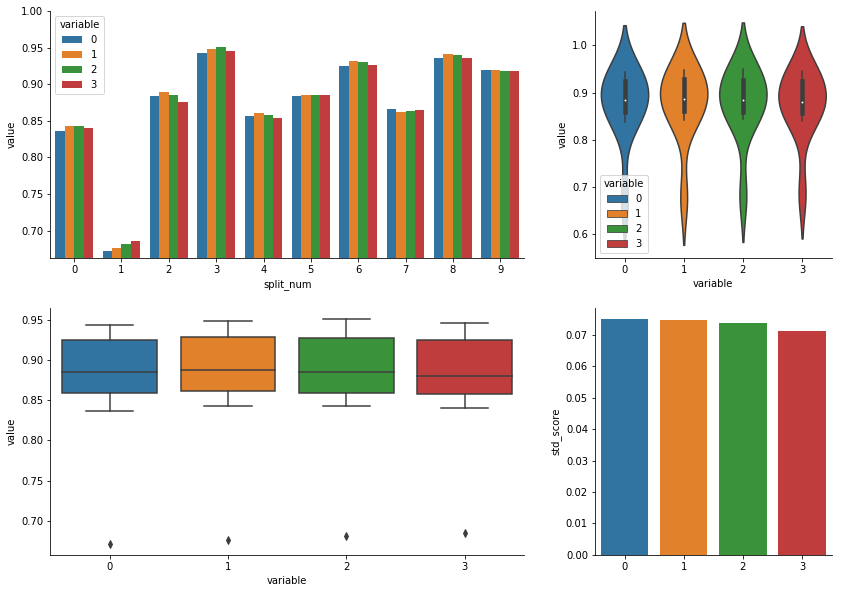

In [477]:
results, cv_results = analyze_results(clf.cv_results_)

In [478]:
# clf C
results

,clf__C,mean_score,std_score,rank
0,1,0.872588,0.074915,4
1,3,0.875889,0.074876,1
2,10,0.875592,0.073643,2
3,30,0.873039,0.071317,3


In [467]:
# COUNT on sites_num find max_feat
results

,feats__pl_text__count__max_features,mean_score,std_score,rank
0,5000,0.866710,0.079719,7
1,8000,0.868556,0.079310,6
2,10000,0.869854,0.080480,5
3,15000,0.870058,0.080325,3
4,20000,0.870057,0.080277,4
5,25000,0.870272,0.080233,2
6,50000,0.870328,0.080248,1


In [462]:
# COUNT on sites_num find max_df and n_gram
results

,feats__pl_text__count__max_df,feats__pl_text__count__ngram_range,mean_score,std_score,rank
0,0.1,"(1, 1)",0.868690,0.081518,2
1,0.1,"(1, 2)",0.864770,0.084686,5
2,0.2,"(1, 1)",0.869854,0.080480,1
3,0.2,"(1, 2)",0.865331,0.084242,4
4,0.3,"(1, 1)",0.865640,0.075904,3
5,0.3,"(1, 2)",0.864722,0.083968,6


In [458]:
# TFIDF on sites_num find binary features
results

,feats__pl_text__tfidf__norm,feats__pl_text__tfidf__use_idf,mean_score,std_score,rank
0,l1,True,0.851279,0.081743,3
1,l1,False,0.845603,0.078184,4
2,l2,True,0.872588,0.074915,1
3,l2,False,0.869540,0.075021,2


In [454]:
# TFIDF on sites_num find binary features
results

,feats__pl_text__tfidf__binary,feats__pl_text__tfidf__smooth_idf,feats__pl_text__tfidf__sublinear_tf,mean_score,std_score,rank
0,True,True,True,0.872248,0.077487,3
1,True,True,False,0.872248,0.077487,3
2,True,False,True,0.872236,0.077471,5
3,True,False,False,0.872236,0.077471,5
4,False,True,True,0.872588,0.074915,1
5,False,True,False,0.869938,0.075274,7
6,False,False,True,0.872584,0.074907,2
7,False,False,False,0.869920,0.075279,8


In [448]:
# TFIDF on sites_num find max_feat
results

,feats__pl_text__tfidf__max_features,mean_score,std_score,rank
0,5000,0.868928,0.075332,7
1,8000,0.869938,0.075274,1
2,10000,0.869377,0.074591,6
3,15000,0.869607,0.074615,5
4,20000,0.869721,0.074630,4
5,25000,0.869725,0.074622,3
6,50000,0.869728,0.074671,2


In [439]:
# TFIDF on sites_num find max_df and n_gram
results

,feats__pl_text__tfidf__max_df,feats__pl_text__tfidf__ngram_range,mean_score,std_score,rank
0,0.1,"(1, 1)",0.869420,0.076220,2
1,0.1,"(1, 2)",0.867631,0.079379,3
2,0.1,"(1, 3)",0.864607,0.081646,5
3,0.2,"(1, 1)",0.869728,0.074671,1
4,0.2,"(1, 2)",0.867434,0.078435,4
5,0.2,"(1, 3)",0.863854,0.080793,6
6,0.3,"(1, 1)",0.863373,0.078525,8
7,0.3,"(1, 2)",0.863557,0.081261,7
8,0.3,"(1, 3)",0.859794,0.084414,9


In [436]:
# TFIDF on sites_num find max_df
results

,feats__pl_text__tfidf__max_df,mean_score,std_score,rank
0,0.10,0.869420,0.076220,3
1,0.15,0.869512,0.076091,2
2,0.20,0.869728,0.074671,1
3,0.25,0.866681,0.077613,4
4,0.30,0.863373,0.078525,5


In [422]:
# TFIDF on sites_dms
results

,feats__pl_text__tfidf__max_features,mean_score,std_score,rank
0,1000.0,0.839395,0.077396,6
1,5000.0,0.848638,0.080481,5
2,10000.0,0.849106,0.079854,1
3,25000.0,0.848911,0.079858,4
4,50000.0,0.848937,0.079883,2
5,NaN,0.848937,0.079883,2


In [418]:
# TFIDF on sites_ds
results

,feats__pl_text__tfidf__max_features,mean_score,std_score,rank
0,5000.0,0.848638,0.080481,6
1,10000.0,0.849106,0.079854,1
2,25000.0,0.848911,0.079858,5
3,50000.0,0.848937,0.079883,2
4,100000.0,0.848937,0.079883,2
5,NaN,0.848937,0.079883,2


In [412]:
# TFIDF on sites_num 
results

,feats__pl_text__tfidf__max_features,mean_score,std_score,rank
0,10000.0,0.863212,0.078470,4
1,25000.0,0.863428,0.078527,1
2,100000.0,0.863373,0.078525,2
3,NaN,0.863373,0.078525,2


In [394]:
# TFIDF on sites 
results

,feats__pl_text__tfidf__max_features,mean_score,std_score,rank
0,1000,0.839395,0.077396,6
1,5000,0.848638,0.080481,5
2,10000,0.849106,0.079854,1
3,25000,0.848911,0.079858,4
4,50000,0.848937,0.079883,2
5,100000,0.848937,0.079883,2


In [388]:
# COUNT on sites_num 
results

,feats__pl_text__count__max_features,mean_score,std_score,rank
0,5000,0.863764,0.075713,5
1,7500,0.864520,0.074875,4
2,10000,0.865640,0.075904,2
3,20000,0.865493,0.075473,3
4,50000,0.865668,0.075458,1


### Save results

In [295]:
clf.refit

pred = clf.predict_proba(X_test)[:, 1]

write_to_submission_file(pred, 'pl_almost_orig.csv')

In [332]:
melted.head()

,variable,value,split_num
0,0,0.989991,1
1,0,0.996261,2
2,0,0.992144,3
3,0,0.991079,4
4,0,0.992333,5


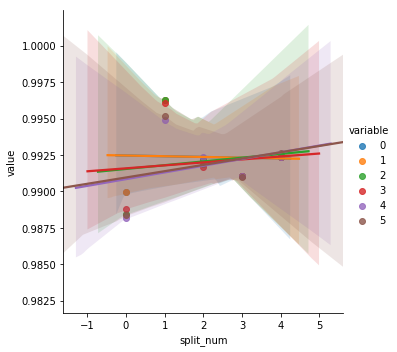

In [341]:
melted = cv_results.melt()
melted['split_num'] = list(range(cv_results.shape[0])) * cv_results.shape[1]

sns.lmplot(x='split_num', y='value', data=melted, fit_reg=True, hue='variable');

## TF-IDF

In [31]:
full_sites_tf = full_sites.copy()

for col in full_sites_tf.columns:
    full_sites_tf[col] = full_sites_tf[col].map(sites_dict.site)

full_sites_tf = full_sites_tf.fillna('')
# df_tf_col = full_sites_tf.apply(lambda x: '.'.join([i for i in x if len(i)>0]), axis=1)
# df_tf_col = df_tf_col.str.split('[.-]').str.join(' ')

df_tf_col = full_sites_tf.apply(lambda x: ' '.join([i for i in x if len(i)>0]), axis=1)

In [32]:
vect = TfidfVectorizer(max_df=.7, sublinear_tf=True)
df_tf = vect.fit_transform(df_tf_col)

#### Split

In [33]:
time_split = TimeSeriesSplit(n_splits=10)

In [34]:
# X_train = df_tf[:idx_split,:]
# X_test = df_tf[idx_split:,:]


X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split,:]])
X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:,:]])

#### GridSearch

In [101]:
c_values = [0.01, 0.03]
# cw_values = [{0: 0.6, 1: 0.4}, {0: 0.9, 1: 0.1}, {0: 0.8, 1: 0.2}, {0: 0.7, 1: 0.3} , {0: 0.3, 1: 0.7}]

lrcv = LogisticRegressionCV(Cs=c_values, scoring='roc_auc', n_jobs=-1, cv=kfold_split,
                            verbose=1, class_weight='balanced', max_iter=3000)

In [102]:
%%time
lrcv.fit(X_train, y_train);
lrcv.score

[Parallel(n_jobs=-1)]: Done   2 out of   8 | elapsed:  8.3min remaining: 24.9min
[Parallel(n_jobs=-1)]: Done   8 out of   8 | elapsed:  8.6min finished


CPU times: user 3min 56s, sys: 2min 36s, total: 6min 33s
Wall time: 10min 39s


In [103]:
cvr = lrcv.scores_[1]
idx = cvr.mean(axis=0).argmax()
for i in range(cvr.shape[1]):
    print(f"ROC_AUC [{lrcv.Cs_[i]:>4}]: {cvr[:, i].mean():.4f}+-{cvr[:, i].std():.4f}")
print(f"Best params: {lrcv.C_}")

ROC_AUC [0.01]: 0.9574+-0.0141
ROC_AUC [0.03]: 0.9587+-0.0136
Best params: [0.03]


ROC_AUC [0.01]: 0.9574+-0.0141
ROC_AUC [0.03]: 0.9587+-0.0136
ROC_AUC [ 0.1]: 0.9586+-0.0127
ROC_AUC [ 0.3]: 0.9578+-0.0123
ROC_AUC [ 1.0]: 0.9559+-0.0129
ROC_AUC [ 3.0]: 0.9531+-0.0142
ROC_AUC [10.0]: 0.9488+-0.0167
Best params: [0.1]

#### Evaluating

In [39]:
X_train = df_tf[:idx_split,:]
X_test = df_tf[idx_split:,:]

# X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split,:]])
# X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:,:]])

In [40]:
params = {'C': 0.1, 'class_weight': 'balanced', 'random_state':17, 'n_jobs':1}

logit = LogisticRegression(**params)

In [41]:
%%time

cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

CPU times: user 791 ms, sys: 159 ms, total: 950 ms
Wall time: 8.32 s


In [42]:
print(f"ROC_AUC: {cv_scores.mean():.4f}+-{cv_scores.std():.4f}")
# cv_scores

ROC_AUC: 0.8537+-0.0796


In [28]:
logit.fit(X_train, y_train)
logit_test_pred = logit.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred, 'subm_not_raw.csv')

### Check columns importance

### Define class_weight

In [109]:
%%time
cv_scores_arr = list()

for cw in [{0: 0.2, 1: 0.8}, {0: 0.3, 1: 0.7}, {0: 0.4, 1: 0.6}]:
    vect = TfidfVectorizer(max_df=0.9, sublinear_tf=True)
    df_tf = vect.fit_transform(df_tf_col)
    params = {'C': 0.1, 'class_weight': cw, 'random_state':17, 'n_jobs':1}
    
    X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split,:]])
    X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:,:]])
    
    logit = LogisticRegression(**params)
    cv_scores_ = cross_val_score(logit, X_train, y_train, cv=kfold_split, scoring='roc_auc', n_jobs=-1)
    cv_scores_arr.append(cv_scores_)
    
    print(f"cw {cw}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f}")

cw {0: 0.2, 1: 0.8}: 0.9542+-0.0159
cw {0: 0.3, 1: 0.7}: 0.9537+-0.0162
cw {0: 0.4, 1: 0.6}: 0.9529+-0.0165
CPU times: user 3min 28s, sys: 22.5 s, total: 3min 51s
Wall time: 8min 35s


cw balanced  : 0.9586+-0.0127
cw {0: 0.9, 1: 0.1}: 0.9390+-0.0209
cw {0: 0.8, 1: 0.2}: 0.9451+-0.0188
cw {0: 0.7, 1: 0.3}: 0.9483+-0.0178
cw {0: 0.6, 1: 0.4}: 0.9504+-0.0172
cw {0: 0.5, 1: 0.5}: 0.9518+-0.0168
cw {0: 0.4, 1: 0.6}: 0.9529+-0.0165
cw {0: 0.3, 1: 0.7}: 0.9537+-0.0162
cw {0: 0.2, 1: 0.8}: 0.9542+-0.0159

### Define good tf-idf params

In [30]:
%%time
params = {'C': 0.1, 'class_weight': 'balanced', 'random_state':17, 'n_jobs':1}
cv_scores_arr = list()

for i in [.5, .6, .7, .8, .9, 1]:
    vect = TfidfVectorizer(max_df=i, sublinear_tf=True)
    df_tf = vect.fit_transform(df_tf_col)
    
    X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split,:]])
    X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:,:]])
    
    logit = LogisticRegression(**params)
    cv_scores_ = cross_val_score(logit, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
    cv_scores_arr.append(cv_scores_)
    
    print(f"max_df {i:<6}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f}")

max_df 0.5   : 0.8736+-0.1068
max_df 0.6   : 0.8742+-0.1057
max_df 0.7   : 0.8742+-0.1057
max_df 0.8   : 0.8736+-0.1061
max_df 0.9   : 0.8738+-0.1067
max_df 1     : 0.8008+-0.0957
CPU times: user 59.3 s, sys: 6.51 s, total: 1min 5s
Wall time: 3min 36s


min_df 0.0001: 0.9581+-0.0129
min_df 0.001: 0.9560+-0.0120
min_df 0.01: 0.9403+-0.0132
min_df 0.1: 0.9110+-0.0209
min_df 0.3: 0.8979+-0.0200

max_df 0.50: 0.9582+-0.0125
max_df 0.60: 0.9583+-0.0126
max_df 0.70: 0.9583+-0.0126
max_df 0.80: 0.9583+-0.0126
max_df 0.85: 0.9583+-0.0126
max_df 0.90: 0.9586+-0.0127
max_df 0.95: 0.9586+-0.0127
max_df 0.98: 0.9586+-0.0127
max_df 1.00: 0.8968+-0.0200

### Define good hour split

In [72]:
good_cols = ['sin_min', 'cos_max', 'n_null', 'dt', 'year', 'morning', 'day', 'evening']
mask = pd.Series(ft_columns).isin(good_cols).values

X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split, mask]])
X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:, mask]])

params = {'C': 0.1, 'class_weight': 'balanced', 'random_state':17, 'n_jobs':1}

logit = LogisticRegression(**params)

cv_scores = cross_val_score(logit, X_train, y_train, cv=kfold_split, 
                            scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

print(f"ROC_AUC: {cv_scores.mean():.4f}+-{cv_scores.std():.4f}")

ROC_AUC: 0.9530+-0.0141


In [80]:
%%time

good_cols = ['sin_min', 'cos_max', 'n_null', 'dt', 'year']
mask = pd.Series(ft_columns).isin(good_cols).values

mask_hours = pd.Series(ft_columns).isin(['hour']).values
hours = pd.Series(full_time[:, mask_hours].flatten())

n_cols = len(ft_columns)
cv_scores_arr = []

for i in range(2, 9):
    hours_dum = pd.get_dummies(pd.cut(hours, bins=i)).values
    
    X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split, mask], hours_dum[:idx_split, :]])
    X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:, mask], hours_dum[idx_split:, :]])
    
    logit = LogisticRegression(**params)
    cv_scores_ = cross_val_score(logit, X_train, y_train, cv=kfold_split, scoring='roc_auc', n_jobs=-1)
    cv_scores_arr.append(cv_scores_)
    
    d_cv = cv_scores_ - cv_scores
    n_pos = (d_cv > 0).sum()
    if not(d_cv.mean() > 0 and n_pos > 4):
        print(f"Bins {i:<10}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f} EXCLUDE")
    else:
        cv_scores = cv_scores_.copy()
        print(f"Bins {i:<10}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f} ADD")

Bins 2         : 0.9465+-0.0194 EXCLUDE
Bins 3         : 0.9418+-0.0187 EXCLUDE
Bins 4         : 0.9583+-0.0126 ADD
Bins 5         : 0.9494+-0.0208 EXCLUDE
Bins 6         : 0.9429+-0.0222 EXCLUDE
Bins 7         : 0.9548+-0.0194 EXCLUDE
Bins 8         : 0.9592+-0.0168 ADD
CPU times: user 1min 29s, sys: 34.6 s, total: 2min 4s
Wall time: 20min 24s


### Delete columns one by one

In [23]:
ft_columns = ['dow', 'weekend', 'day_', 'month', 'sin_min', 'cos_min', 'dt', 'dt_std', 'dt_mean', 'n_null',
              'sin_max', 'cos_max', 'hour', 'year', 'minutes', 'myear', 'bin1', 'bin2', 'bin3', 'bin4']  # full_time.columns

In [24]:
cv_scores.mean()

0.8735747277102843

In [25]:
%%time

params = {'C': 0.1, 'class_weight': 'balanced', 'random_state':17, 'n_jobs':1}

n_cols = len(ft_columns)
cv_scores_all = list()
delete_dict = {col:0 for col in ft_columns}
boundary = time_split.n_splits * 7 // 10

for iter_ in range(10):
    print(f"Iter {iter_}")
    idx_order = list(range(n_cols))
    np.random.seed(iter_)
    np.random.shuffle(idx_order)
    cv_scores_n_ = cv_scores.copy()
    cv_scores_arr = list()
    mask = np.ones(n_cols, dtype='bool')
    
    for n_ in range(-n_cols, 0):
        i = idx_order[n_]
        mask[i] = False
        X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split, mask]])
        X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:, mask]])
        logit = LogisticRegression(**params)
        cv_scores_ = cross_val_score(logit, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
        cv_scores_arr.append(cv_scores_)

        d_cv = cv_scores_ - cv_scores_n_
        n_neg = (d_cv > 0).sum()
        if d_cv.mean() > 0 and n_neg >= boundary:
            delete_dict[ft_columns[i]] += 1
            cv_scores_n_ = cv_scores_.copy()
            print(f"{ft_columns[i]:<10}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f} EXCLUDE  ")
        else:
            mask[i] = True
            print(f"{ft_columns[i]:<10}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f} OK  ")
    cv_scores_all.append(cv_scores_arr)
    print('*' * 30)

Iter 0
bin3      : 0.8723+-0.1060 OK  
weekend   : 0.8803+-0.1304 EXCLUDE  
bin4      : 0.8800+-0.1307 OK  
dt_mean   : 0.8804+-0.1302 EXCLUDE  
sin_max   : 0.8804+-0.1304 OK  
bin2      : 0.8813+-0.1266 OK  
dt        : 0.8802+-0.1307 OK  
year      : 0.8803+-0.1301 OK  
sin_min   : 0.8803+-0.1304 OK  
day_      : 0.8803+-0.1300 OK  
cos_min   : 0.8803+-0.1301 OK  
minutes   : 0.8801+-0.1309 OK  
n_null    : 0.8812+-0.1328 OK  
dt_std    : 0.8804+-0.1303 OK  
bin1      : 0.8804+-0.1304 OK  
cos_max   : 0.8803+-0.1304 OK  
month     : 0.8803+-0.1303 OK  
dow       : 0.8799+-0.1290 OK  
myear     : 0.8804+-0.1300 OK  
hour      : 0.8806+-0.1304 EXCLUDE  
******************************
Iter 1
month     : 0.8731+-0.1065 OK  
bin1      : 0.8744+-0.1054 OK  
dt        : 0.8736+-0.1061 OK  
sin_max   : 0.8736+-0.1062 OK  
day_      : 0.8744+-0.1061 OK  
minutes   : 0.8736+-0.1062 OK  
sin_min   : 0.8735+-0.1062 OK  
bin2      : 0.8748+-0.0999 OK  
dt_std    : 0.8736+-0.1061 OK  
weekend   : 

Process ForkPoolWorker-508:
Process ForkPoolWorker-507:
Traceback (most recent call last):


KeyboardInterrupt: 

### Add columns one by one

In [ ]:
%%time

params = {'C': 0.1, 'class_weight': 'balanced', 'random_state':17, 'n_jobs':1}

n_cols = len(ft_columns)
cv_scores_arr = []
mask = np.zeros(n_cols, dtype='bool')
for i in range(-n_cols, 0):
    if 'dt_time' not in ft_columns[i]:
        mask[i] = True
        X_train = hstack([df_tf[:idx_split,:], full_time[:idx_split, mask]])
        X_test = hstack([df_tf[idx_split:,:], full_time[idx_split:, mask]])
        logit = LogisticRegression(**params)
        cv_scores_ = cross_val_score(logit, X_train, y_train, cv=time_split, scoring='roc_auc', n_jobs=-1)
        cv_scores_arr.append(cv_scores_)

        d_cv = cv_scores_ - cv_scores
        n_pos = (d_cv > 0).sum()
        if not(d_cv.mean() > 0 and n_pos > d_cv.shape[0]/2):
            mask[i] = False
            print(f"{ft_columns[i]:<10}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f} EXCLUDE  ")
        else:
            cv_scores = cv_scores_.copy()
            print(f"{ft_columns[i]:<10}: {cv_scores_.mean():.4f}+-{cv_scores_.std():.4f} ADD  ")

dow       : 0.8544+-0.0874 EXCLUDE
weekend   : 0.8399+-0.0972 EXCLUDE
day_      : 0.8523+-0.0798 EXCLUDE
month     : 0.8552+-0.0807 ADD
sin_min   : 0.9028+-0.0783 ADD
cos_min   : 0.8915+-0.0949 EXCLUDE
dt        : 0.9019+-0.0794 EXCLUDE
dt_std    : 0.9028+-0.0788 EXCLUDE
dt_mean   : 0.9016+-0.0794 EXCLUDE
n_null    : 0.9020+-0.0756 EXCLUDE
morning   : 0.8923+-0.0966 EXCLUDE
day       : 0.9008+-0.0817 EXCLUDE
evening   : 0.9057+-0.0756 ADD
sin_max   : 0.9057+-0.0756 ADD
cos_max   : 0.8854+-0.1113 EXCLUDE
hour      : 0.9007+-0.0837 EXCLUDE
year      : 0.9099+-0.0767 ADD
minutes   : 0.9054+-0.0844 EXCLUDE

In [ ]:
good_cols = ['sin_min', 'cos_max', 'n_null', 'dt', 'year', 'morning', 'day', 'evening']

TfidfVectorizer df_tf + time  max_df=.7 sublinear_tf=True
ROC_AUC: 0.9168+-0.0542
Best params: {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}}

TfidfVectorizer df_tf + time  max_df=.7
ROC_AUC: 0.9148+-0.0504
Best params: {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}}

TfidfVectorizer df_tf + time  max_df=.8
ROC_AUC: 0.9125+-0.0538
Best params: {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}}

TfidfVectorizer df_tf + time
ROC_AUC: 0.9115+-0.0546
Best params: {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}}

TfidfVectorizer df_tf + time (sites name full)
ROC_AUC: 0.9115+-0.0546
Best params: {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}}

TfidfVectorizer df_tf
ROC_AUC: 0.8575+-0.0753
Best params: {'C': 20, 'class_weight': {0: 0.6, 1: 0.4}}

CountVectorizer df_tf
ROC_AUC: 0.8351+-0.0763
Best params: {'C': 10, 'class_weight': {0: 0.6, 1: 0.4}}

#### To submit

In [38]:
logit_test_pred = logit_grid_searcher.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred, 'pred/a_sub_new_df_tfidf_drop_dub.csv')

# Lets watch origin

User sessions are chosen in the way they are not longer than half an hour or/and contain more than ten websites. I.e. a session is considered as ended either if a user has visited ten websites or if a session has lasted over thirty minutes.

There are some empty values in the table, it means that some sessions contain less than ten websites. Replace empty values with 0 and change columns types to integer. Also load the websites dictionary and check how it looks like:

**Пользовательские сессии выбираются так, чтобы они не превышали получаса или / и содержали более десяти веб-сайтов. То есть сеанс считается завершенным, если пользователь посетил десять веб-сайтов или если сеанс длится более тридцати минут.**  

**В таблице есть несколько пустых значений, это означает, что некоторые сеансы содержат менее десяти веб-сайтов. Замените пустые значения на 0 и измените типы столбцов на integer. Также загрузите словарь веб-сайтов и проверьте, как это выглядит:**

In [19]:
df_alice = pd.read_csv('data/train/Alice_log.csv')
df_alice.head(5)

,timestamp,site
0,2013-02-12 16:25:10,api.bing.com
1,2013-02-12 16:25:11,api.bing.com
2,2013-02-12 16:32:10,api.bing.com
3,2013-02-12 16:32:11,www.google.fr
4,2013-02-12 16:32:24,www.google.fr


In [9]:
df_user0010 = pd.read_csv('data/train/other_user_logs/user0010.csv')
df_user0010.head(5)

,timestamp,site
0,2013-12-18 10:19:27,ocsp.digicert.com
1,2013-12-18 10:19:28,ocsp.digicert.com
2,2013-12-18 10:19:28,clients1.google.com
3,2013-12-18 10:19:29,gtglobal-ocsp.geotrust.com
4,2013-12-18 10:19:29,clients1.google.com


In [13]:
full_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0,NaT
77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,2013-01-12 08:50:16,945,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17
114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,2013-01-12 08:50:18,946,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20
146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,2013-01-12 08:50:21,952,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22


In [18]:
train_df[train_df['target']==1].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2297 entries, 251175 to 244233
Data columns (total 21 columns):
site1     2297 non-null int32
time1     2297 non-null datetime64[ns]
site2     2297 non-null int32
time2     2294 non-null datetime64[ns]
site3     2297 non-null int32
time3     2287 non-null datetime64[ns]
site4     2297 non-null int32
time4     2286 non-null datetime64[ns]
site5     2297 non-null int32
time5     2280 non-null datetime64[ns]
site6     2297 non-null int32
time6     2273 non-null datetime64[ns]
site7     2297 non-null int32
time7     2269 non-null datetime64[ns]
site8     2297 non-null int32
time8     2263 non-null datetime64[ns]
site9     2297 non-null int32
time9     2262 non-null datetime64[ns]
site10    2297 non-null int32
time10    2258 non-null datetime64[ns]
target    2297 non-null int64
dtypes: datetime64[ns](10), int32(10), int64(1)
memory usage: 305.1 KB


In [60]:
DT = 30

df_alice = pd.read_csv('data/train/Alice_log.csv')
df_alice['timestamp'] = df_alice['timestamp'].apply(pd.to_datetime)
for i in range(-1, -10, -1):
    df_alice['timestamp' + str(-i+1)] = df_alice['timestamp'].shift(i)
    df_alice['site' + str(-i+1)] = df_alice['site'].shift(i)
    
    df_alice['dt'] = (df_alice['timestamp' + str(-i+1)] - df_alice['timestamp']).dt.seconds / 60
    df_alice.loc[df_alice['dt']>DT, ['timestamp' + str(-i+1), 'site' + str(-i+1)]] = None

del df_alice['dt']

to_int = dict(zip(sites_dict['site'], sites_dict.index))
for col in df_alice.columns:
    if 'site' in col:
        df_alice[col] = df_alice[col].map(to_int)

# df_alice['dt'] = (df_alice['timestamp'].shift(-1) - df_alice['timestamp']).dt.seconds / 60
# df_alice['dt_10sites'] = (df_alice['timestamp'].shift(-10) - df_alice['timestamp']).dt.seconds / 60
df_alice.head()

,timestamp,site,timestamp2,site2,timestamp3,site3,timestamp4,site4,timestamp5,site5,timestamp6,site6,timestamp7,site7,timestamp8,site8,timestamp9,site9,timestamp10,site10
0,2013-02-12 16:25:10,270,2013-02-12 16:25:11,270.0,2013-02-12 16:32:10,270.0,2013-02-12 16:32:11,21.0,2013-02-12 16:32:24,21.0,2013-02-12 16:32:25,7832.0,2013-02-12 16:32:25,21.0,2013-02-12 16:32:26,7832.0,2013-02-12 16:32:27,30.0,2013-02-12 16:32:27,7832.0
1,2013-02-12 16:25:11,270,2013-02-12 16:32:10,270.0,2013-02-12 16:32:11,21.0,2013-02-12 16:32:24,21.0,2013-02-12 16:32:25,7832.0,2013-02-12 16:32:25,21.0,2013-02-12 16:32:26,7832.0,2013-02-12 16:32:27,30.0,2013-02-12 16:32:27,7832.0,2013-02-12 16:32:27,29.0
2,2013-02-12 16:32:10,270,2013-02-12 16:32:11,21.0,2013-02-12 16:32:24,21.0,2013-02-12 16:32:25,7832.0,2013-02-12 16:32:25,21.0,2013-02-12 16:32:26,7832.0,2013-02-12 16:32:27,30.0,2013-02-12 16:32:27,7832.0,2013-02-12 16:32:27,29.0,2013-02-12 16:32:28,7832.0
3,2013-02-12 16:32:11,21,2013-02-12 16:32:24,21.0,2013-02-12 16:32:25,7832.0,2013-02-12 16:32:25,21.0,2013-02-12 16:32:26,7832.0,2013-02-12 16:32:27,30.0,2013-02-12 16:32:27,7832.0,2013-02-12 16:32:27,29.0,2013-02-12 16:32:28,7832.0,2013-02-12 16:32:29,37.0
4,2013-02-12 16:32:24,21,2013-02-12 16:32:25,7832.0,2013-02-12 16:32:25,21.0,2013-02-12 16:32:26,7832.0,2013-02-12 16:32:27,30.0,2013-02-12 16:32:27,7832.0,2013-02-12 16:32:27,29.0,2013-02-12 16:32:28,7832.0,2013-02-12 16:32:29,37.0,2013-02-12 16:32:34,7832.0
